In [1]:
import pickle
import pandas as pd
import numpy as np
from VenusOpt.utils import loadXy

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn_evaluation import plot
import sklearn
import matplotlib.pyplot as plt


RANDSTATE = 42

In [5]:
X, y, X_var = loadXy("../New Data/accumulated_weekend_data.h5", run_idx='3')
X.shape, y.shape, X_var.shape

((941, 3), (941,), (941,))

In [10]:
# hyper parameters
param_grid = [
  {'kernel__length_scale':[0.8, 1.0], 'kernel__nu':[0.66, 0.86]},
]

kernel = Matern(nu=1.5, length_scale_bounds=(1, 1e10)) 
kernel_RBF = RBF(length_scale_bounds="fixed")
#TODO: check if we want sklearn to autofit some of these paramters

gpr = GaussianProcessRegressor(
    kernel=kernel, alpha=X_var.mean(), n_restarts_optimizer=9
)

out = sklearn.model_selection.cross_val_score(gpr, X, y, cv=5)


In [ ]:
out

array([-0.00427885, -0.00168121, -0.00029284, -0.01368456, -0.00891658])

In [13]:
# hyper parameters
param_grid = [
  {'kernel__length_scale':[0.8, 1.0], 'kernel__nu':[0.66, 0.86]},
]

kernel = Matern(length_scale_bounds="fixed") 
kernel_RBF = RBF(length_scale_bounds="fixed")
#TODO: check if we want sklearn to autofit some of these paramters

gpr = GaussianProcessRegressor(
    kernel=kernel, alpha=X_var.mean(), n_restarts_optimizer=9
) 

clf = GridSearchCV(estimator=gpr, param_grid=param_grid)
clf.fit(X, y)
with open("../Results/gs_clf.dump" , "wb") as f:
    pickle.dump(clf, f)


## Result Inspection

In [37]:
run_num = "3"
with open("../Results/gs_clf_run%s_nu10.000000to60.000000_l0.100000to10.000000.dump"%run_num , "rb") as f:
        clf_loaded = pickle.load(f)


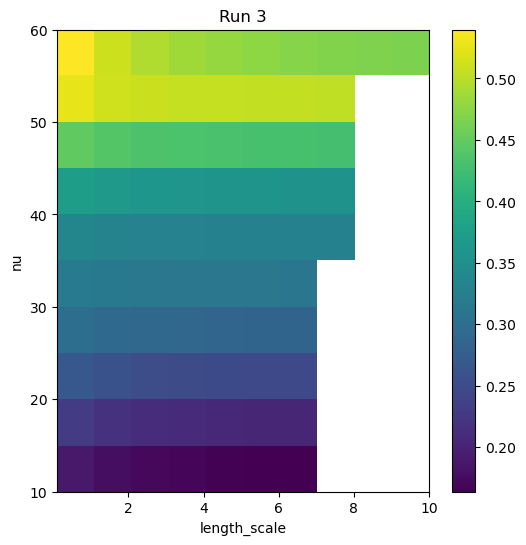

{'kernel__length_scale': 1.2000000000000002, 'kernel__nu': 54.44444444444444}


In [38]:
clf_loaded.cv_results_

results = clf_loaded.cv_results_['mean_test_score'].reshape((10, 10))

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(results, extent=(0.1,10,10,60))
ax.set_aspect("auto")
plt.xlabel("length_scale")
plt.ylabel("nu")
plt.title("Run %s"%run_num)
plt.colorbar(im)
plt.savefig("../Graphs/gs_run%s.png"%run_num)
plt.show()
print(clf_loaded.cv_results_['params'][results.argmax()])

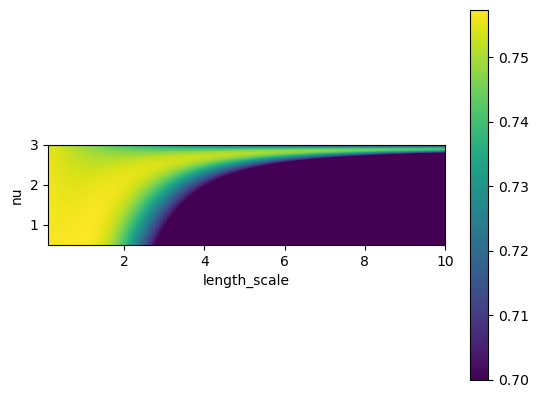

{'kernel__length_scale': 10.0, 'kernel__nu': 0.702020202020202}


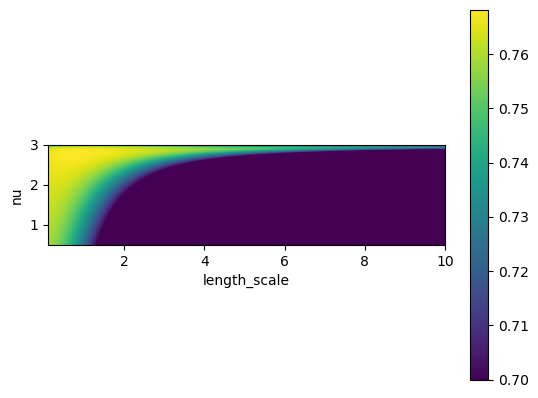

{'kernel__length_scale': 1.0, 'kernel__nu': 0.6767676767676768}


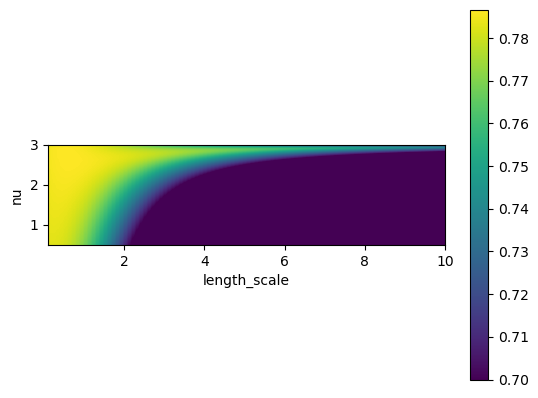

{'kernel__length_scale': 1.4000000000000001, 'kernel__nu': 0.6262626262626263}


In [4]:
for i in ['1','2','3']:
    with open("../Results/gs_clf_trial%s.dump"%i , "rb") as f:
        clf_loaded = pickle.load(f)
    results = clf_loaded.cv_results_['mean_test_score'].reshape((100, 100))
    im = plt.imshow(results, extent=(0.1,10,0.5,3), vmin=0.7)
    plt.xlabel("length_scale")
    plt.ylabel("nu")
    plt.colorbar(im)
    plt.show()
    print(clf_loaded.cv_results_['params'][results.argmax()])

In [48]:
results.max()

0.7865858052405486

In [49]:
results.argmax()

1305

In [50]:
clf_loaded.cv_results_['params'][results.argmax()]

{'kernel__length_scale': 1.4000000000000001, 'kernel__nu': 0.6262626262626263}